In [1069]:
import numpy as np
import matplotlib.pyplot as plt


#plt.rcParams['figure.figsize'] = [4.0, 4.0]
plt.rcParams['figure.dpi'] = 50

#plt.style.use('ggplot')

In [1105]:
#Assignment of values of different parameters:
alpha = 2.25
r = 3
gamma = 0.0
delta_j = 0.018
delta_h = 0.105
delta_i = 0.0177
delta_p = 0.105
tau_h = 9   
tau_p = 12
epsilon_s = .3
epsilon_d = .2
s_ds = .65
s_sd = 1
C = 1
s_ss = 1
s_dd = 1
epsilon = 1e-6
eta = 0

In [1106]:
# assume all model parameters are defined globally

def Phi_k(Js, Jd, k):
    if k == 's':
        numerator = alpha * (Js + s_ds * Jd)
        denominator = (Js + Jd + epsilon) * (1 +  gamma * numerator)
    elif k == 'd':
        numerator = alpha * (s_sd * Js +  Jd)
        denominator = (Js + Jd + epsilon) * (1 +  gamma * numerator ) 
    else:
        raise ValueError('inappropriate value for k ...')
    
    return numerator / denominator

def R_k(Js, Jd, Hs, Hd, k):
    # assume C is a global variable
    J = Js + Jd
    H = Hs + Hd
    factor = 1  - (J + H) / C
    
    if k == 'd':
        return  (r - eta) * Hd * factor
    elif k == 's':
        return  r * Hs * factor
    else:
        raise ValueError('inappropriate value for k ...')


def D_jk(Js, Jd, P, k):
    if k == 's':
        return delta_j  + epsilon_s * Phi_k(Js, Jd, 's') * P
    elif k == 'd':
        return delta_j + epsilon_d * Phi_k(Js, Jd, 'd') * P
    else:
        raise ValueError('inappropriate value for k ...')

def R_i(Js, Jd, P):
    return (epsilon_s * Phi_k(Js, Jd, k='s') * Js + epsilon_d * Phi_k(Js, Jd, k='d') * Jd) * P

def D_hk():
    return delta_h

def D_i():
    return delta_i

def D_p():
    return delta_p
        

def history(D_hist, D_new):
    # keep only function values at from t - τ to t, where τ = delay_size
    
    del D_hist[0]          # delete oldest value
    D_hist.append(D_new)   # add new value
            

def delay_integral(D_hist, step_size):
    # use the trapezoidal rule (composite)
    # R_hist contains function values at the time points of interest
    # assume same step size for the quadrature and the integration
    # otherwise would require too many function evaluations that are not necessary
    
    return step_size * ((D_hist[0] + D_hist[-1]) * 0.5 + sum(D_hist[1:-1]))

def M_k(R_k_hist, D_jk_hist, step_size):
    # note that R_k_hist = R_k(t - τ) but
    # D_jk_hist contains the whole history of D_jk from t - τ to t
    return np.array(R_k_hist) * np.exp(- delay_integral(D_jk_hist, step_size))

def M_i(R_i_hist):
    # note that R_i_hist = R_i(t - τ)
    # we leverage the fact that D_i(t) = δ_i
    return np.array(R_i_hist) * np.exp(- delta_i * tau_p)

In [1107]:
def rk4_method(f, u0, tspan, step_size):    #RK4-Method defined for the stage structured-model
    '''
    Runge-Kutta Method of order 4
    Inputs: -- f: vector field, u' = f(t, u): function
    -- u0: initial condition: array or list
    -- tspan == (t0, tf) or [t0, ts]
    -- N: number of steps
    Output: ndarray
    '''
    h = step_size                                             # time step
    d = len(u0)                                               # number of variables
    N = int((tspan[1] - tspan[0]) / h)                             # number of steps
    u = np.empty((N + 1, d), dtype='float64')                                  # solution vector
    u[0, : ] = u0                                              # start with u0
    t = np.linspace(tspan[0], tspan[1], N, endpoint=True)     # time steps
    
    #Run RK4 method
    for i in range(N):
        k1 = h*f(u[i, :], step_size)
        k2 = h*f(u[i, :] + k1 / 2, step_size)
        k3 = h*f(u[i, :] + k2 / 2, step_size)
        k4 = h*f(u[i, :] + k3, step_size)
        u[i+1,:] = u[i, :] + (k1 + 2*k2 + 2*k3 + k4) / 6
    return u

In [1108]:
#Dealay Diff Eqns:

In [1109]:
def F(U, step_size):
    # we assume all parameters and histories are global variables with the exact same names
    # could make them local, though
    Js, Jd, Hs, Hd, P = U
    
    R_s_new = R_k(Js, Jd, Hs, Hd, k='s')
    R_d_new = R_k(Js, Jd, Hs, Hd, k='d')
    R_i_new = R_i(Js, Jd, P)
    D_js_new = D_jk(Js, Jd, P, k='s')
    D_jd_new = D_jk(Js, Jd, P, k='d')
    
    # update histories
    history(R_s_hist, R_s_new)
    history(R_d_hist, R_s_new)
    history(R_i_hist, R_i_new)
    history(D_js_hist, D_js_new)
    history(D_jd_hist, D_jd_new)
    
    
    # evaluate derivatives (vector field)
    dJs_dt = R_s_new - Js * D_jk(Js, Jd, P, k='s') - M_k(R_s_hist[0], D_js_hist, step_size)
    dJd_dt = R_d_new - Jd * D_jk(Js, Jd, P, k='d') - M_k(R_d_hist[0], D_jd_hist, step_size)
    dHs_dt = M_k(R_s_hist[0], D_js_hist, step_size) - Hs * delta_h
    dHd_dt = M_k(R_d_hist[0], D_jd_hist, step_size) - Hd * delta_h
    dP_dt  = M_i(R_i_hist[0]) - delta_p * P
    
    #print(R_s_new, "     ", M_k(R_s_hist[0], D_js_hist, step_size))
    
    return np.array([dJs_dt, dJd_dt, dHs_dt, dHd_dt, dP_dt])
    

In [1112]:
tf = 1000
tspan = [0, tf]  
step_size = .5

u0 = [0.1, 0.1, 0.4, 0.2, 0.1]     # initial condition
# init and past values
js, jd, hs, hd, p = u0

# use the same value for past 
n_h = int(tau_h / step_size)
n_p = int(tau_p / step_size)

js = [js] * max(n_h, n_p)  
jd = [jd] * max(n_h, n_p)
hs = [hs] * max(n_h, n_p)
hd = [hd] * max(n_h, n_p)
p = [p] * max(n_h, n_p)

# sums
j = js + jd
h = hs + hd



# initialize histories
R_s_hist = list(np.zeros(n_h))
R_d_hist = list(np.zeros(n_h))
R_i_hist = list(np.zeros(n_p))
D_js_hist = list(np.zeros(n_h))
D_jd_hist = list(np.zeros(n_h))

sol = rk4_method(F, u0, tspan, step_size)

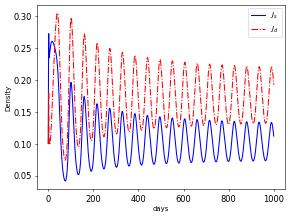

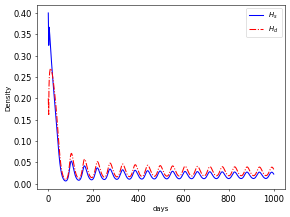

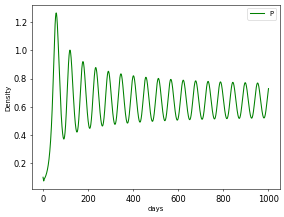

In [1113]:
labels = ['$J_s$', '$J_d$', '$H_s$', '$H_d$', 'P']

for i in range(5):
    if i == 1:
        plt.plot(np.linspace(0, tf, len(sol[:,i])), sol[:,i], 'r-.',  label=labels[i])
        plt.xlabel("days")
        plt.ylabel("Density")
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend()
        #plt.title("Juvenile aphids", fontsize=18)
        plt.show()
    elif i == 3:
        plt.plot(np.linspace(0, tf, len(sol[:,i])), sol[:,i], 'r-.', label=labels[i])
        plt.xlabel("days")
        plt.ylabel("Density")
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend()
        #plt.title("Adult aphids", fontsize=18)
        plt.show()
    elif i==4:
        plt.plot(np.linspace(0, tf, len(sol[:,i])), sol[:,i], 'g-', label=labels[i])
    else:
        plt.plot(np.linspace(0, tf, len(sol[:,i])), sol[:,i], 'b-', label=labels[i])
        
plt.xlabel("days")
plt.ylabel("Density")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
#plt.title("Parasitoids", fontsize=18)
plt.show()